In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
sorted_dd_list

['DD0138',
 'DD0238',
 'DD0287',
 'DD0293',
 'DD0338',
 'DD0438',
 'DD0538',
 'DD0638',
 'DD0738',
 'DD0838',
 'DD0938',
 'DD1038',
 'DD1138',
 'DD1238',
 'DD1338',
 'DD1438',
 'DD1477',
 'DD1478',
 'DD1479',
 'DD1538',
 'DD1638',
 'DD1738',
 'DD1838',
 'DD1938',
 'DD2038',
 'DD2138',
 'DD2238',
 'DD2288',
 'DD2289',
 'DD2338',
 'DD2427']

In [8]:
redshiftlist = []
cutofflist = []
pngfile = []
    
snap = "DD1477" # name of the snapshot output
snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives
field = "density"
axis = "y" 
width = 200 #[kpc]
resolution = 70 #[pixel]
quantitylabel = 'Density [log 10 g/cm^2]'
max_radius = width/2 #[kpc]
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]
markersize = 10
fontsize = 15 
plotlabel_linedot = 'Binned mean density'
plotlabel_segment = 'Fitted density'

In [9]:
ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                             disk_relative=False, do_filter_particles=False, masses_dir=track_dir)

frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

np.array(frb["gas",field])

OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

#print(OD_Qua)

radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)

#print(quantitylist)

p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist))

#print(p)
#p for popt (optimization parameter), e for pcov (covariance of popt)
#This is where error is happening 


#plt.savefig(output_dir + snap + _Density_Profile.jpg)

redpara = ds.get_parameter("CosmologyCurrentRedshift")
redshiftlist.append(redpara)
cutofflist.append(p[0])


yt : [INFO     ] 2023-07-17 11:01:59,313 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-17 11:01:59,314 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 11:01:59,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 11:01:59,315 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 11:01:59,316 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 11:01:59,317 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-17 11:01:59,318 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 11:01:59,318 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 11:01:59,319 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 11:01:59,320 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:00<00:00, 6566.08it/s]
yt : [INFO     ] 2023-07-17 11:02:04,859 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 11:02:11,775 Projection completed
yt : [INFO     ] 2023-07-17 11:02:11,777 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


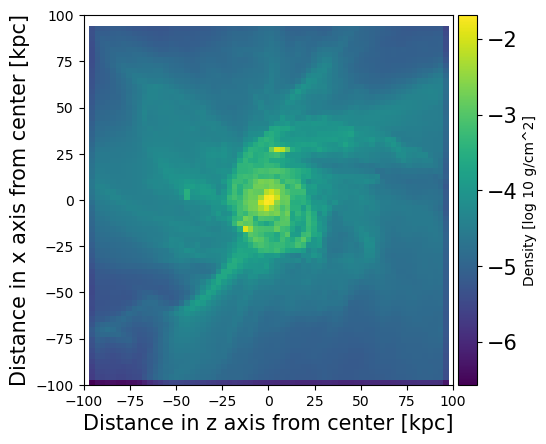

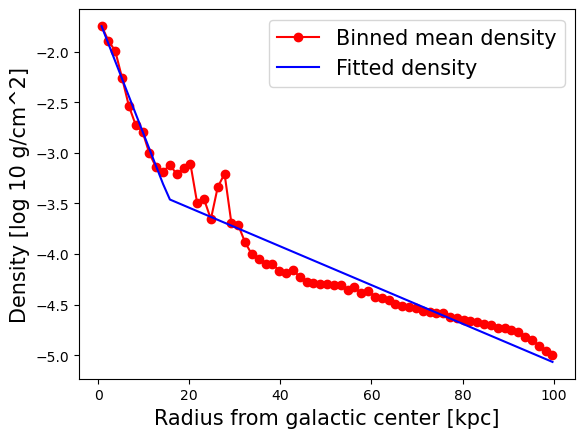

In [10]:
projection_plot = projection(frb, field, width, quantitylabel, axis, fontsize = 15)
segment_plot = plotting(radiuslist, np.log10(quantitylist), piecewise_linear(radiuslist, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)


In [11]:
redpara = ds.get_parameter("CosmologyCurrentRedshift")
redshiftlist.append(redpara)
cutofflist.append(p[0])

In [12]:
np.array(frb["gas",field])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.19397541e-06, 6.68325152e-06, ...,
        6.70055041e-06, 2.97921565e-06, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.17190831e-06, 3.29587673e-06, ...,
        9.39679374e-06, 4.05645065e-06, 0.00000000e+00],
       [0.00000000e+00, 1.97905978e-06, 2.94175254e-06, ...,
        9.19209172e-06, 3.89828241e-06, 0.00000000e+00],
       [0.00000000e+00, 2.71034899e-07, 4.06167153e-07, ...,
        1.30468035e-06, 5.48912602e-07, 0.00000000e+00]])

In [13]:
quantitylist

[0.017960156864164818,
 0.012830765579838713,
 0.010165134545193358,
 0.005501889758302496,
 0.002900442699544728,
 0.0018841104246227378,
 0.0016138955424572338,
 0.000987390994151039,
 0.0007182661459693101,
 0.0006499408478892802,
 0.0007654818063727952,
 0.0006129462841381782,
 0.0007096787063419057,
 0.0007817515773898664,
 0.00031676484313561426,
 0.0003481781533515548,
 0.00022143454976565106,
 0.0004578974075919591,
 0.0006222206794839062,
 0.00020309605902114512,
 0.00019364479395504538,
 0.00013091976162519185,
 9.917524372558674e-05,
 8.903335506132851e-05,
 8.011502040472235e-05,
 8.062743565228902e-05,
 6.78522032770883e-05,
 6.456480585174438e-05,
 7.016674277311743e-05,
 5.935008065313237e-05,
 5.2509574442510996e-05,
 5.171295153867825e-05,
 5.100827640192981e-05,
 5.093051248639869e-05,
 4.9268293730485854e-05,
 4.9034687203016644e-05,
 4.39426743939933e-05,
 4.683305109224501e-05,
 4.095186530573289e-05,
 4.352054740763781e-05,
 3.79383743480895e-05,
 3.68715031512543

yt : [INFO     ] 2023-07-17 11:02:16,793 Projection completed
yt : [INFO     ] 2023-07-17 11:02:16,794 xlim = 48474.192982 48674.192982
yt : [INFO     ] 2023-07-17 11:02:16,795 ylim = 47007.115667 47207.115667
yt : [INFO     ] 2023-07-17 11:02:16,795 xlim = 0.505620 0.507706
yt : [INFO     ] 2023-07-17 11:02:16,796 ylim = 0.490318 0.492404
yt : [INFO     ] 2023-07-17 11:02:16,798 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



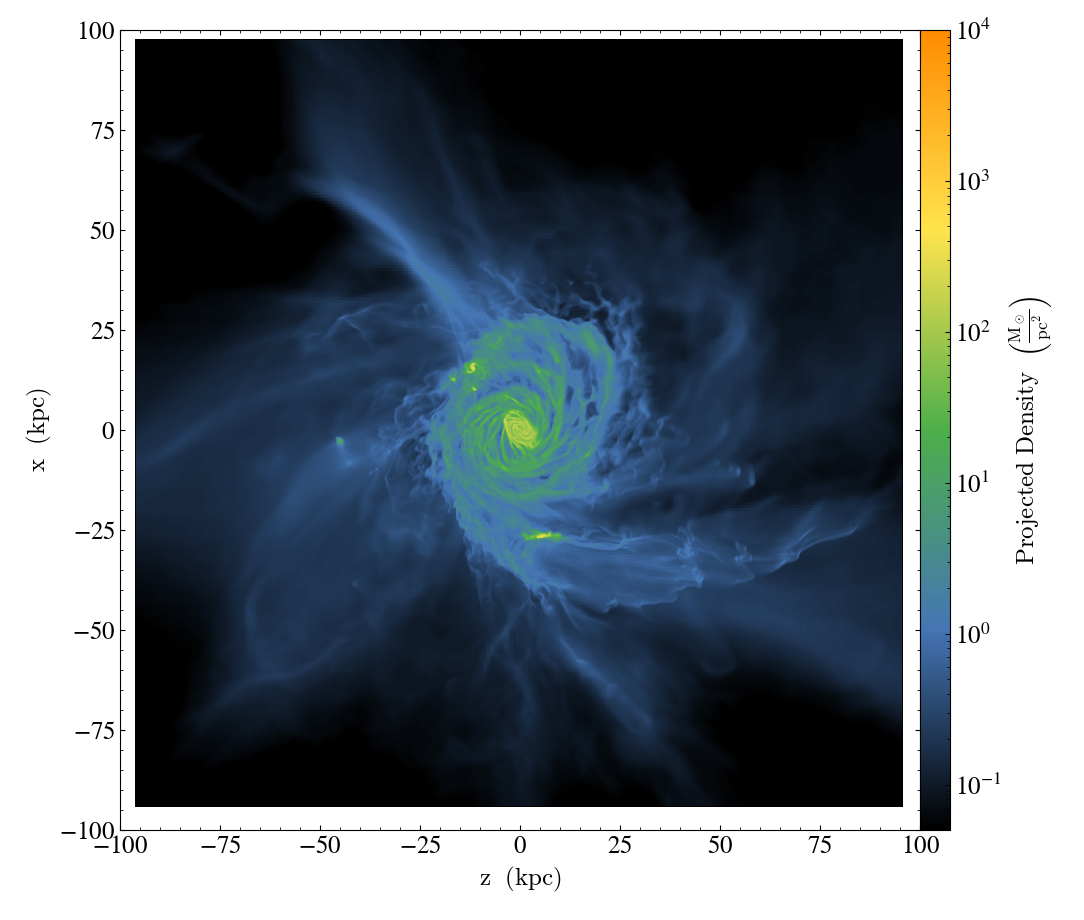

In [14]:
proj = yt.ProjectionPlot(ds, "y", ('gas', 'density'), center=ds.halo_center_kpc, width=(200., 'kpc'), data_source=refine_box)
proj.set_unit('density', 'Msun/pc**2')           # change the units of the density to solar masses per square parsec
proj.set_cmap('density', density_color_map)      # change the color map used
proj.set_zlim('density', density_proj_min, density_proj_max)